In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.signal import lombscargle

from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import scipy as sp
from BCTable import BC_Av_Table
from pathlib import Path
from matplotlib.ticker import MaxNLocator
import string

import os

from pysep.io.trk.read import read_trk
from pysep.io.mod.read import read_bin_mod

from mplEasyAnimate import animation
from tqdm import tqdm

In [6]:
bgColor = "#F0F1EB"

In [53]:
def add_kde_to_ax(x, y, ax, *args, **kwargs):
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()
    
    X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    
    kde = gaussian_kde(np.vstack((x, y)))
    
    Z = np.reshape(kde(positions).T, X.shape)
    norm=plt.Normalize(Z.min(),Z.max())
    cmap = LinearSegmentedColormap.from_list("", [bgColor,"violet","blue"])
    
    ax.imshow(np.rot90(Z), cmap=cmap,
              extent=[xmin, xmax, ymin, ymax], aspect='auto', *args, **kwargs)
    return cmap

In [84]:
Salpeter = np.vectorize(lambda m, dm, xi0: quad(lambda m : xi0*(m)**(-2.35), m, m+dm)[0])
Kroupa = np.vectorize(lambda m, dm, xi0: quad(lambda m: xi0*m**-0.3 if m < 0.08 else (xi0*m**(-1.3) if 0.08 < m < 0.5 else xi0*m**(-2.3)), m, m+dm)[0])
ChabrierSingle = np.vectorize(lambda m, dm, xi0: (0.158*(1/np.log(10)*m)*np.exp((-(np.log(m)-np.log(0.08))**2)/(2*0.69**2)) if m < 1 else xi0*m**(-2.3)))

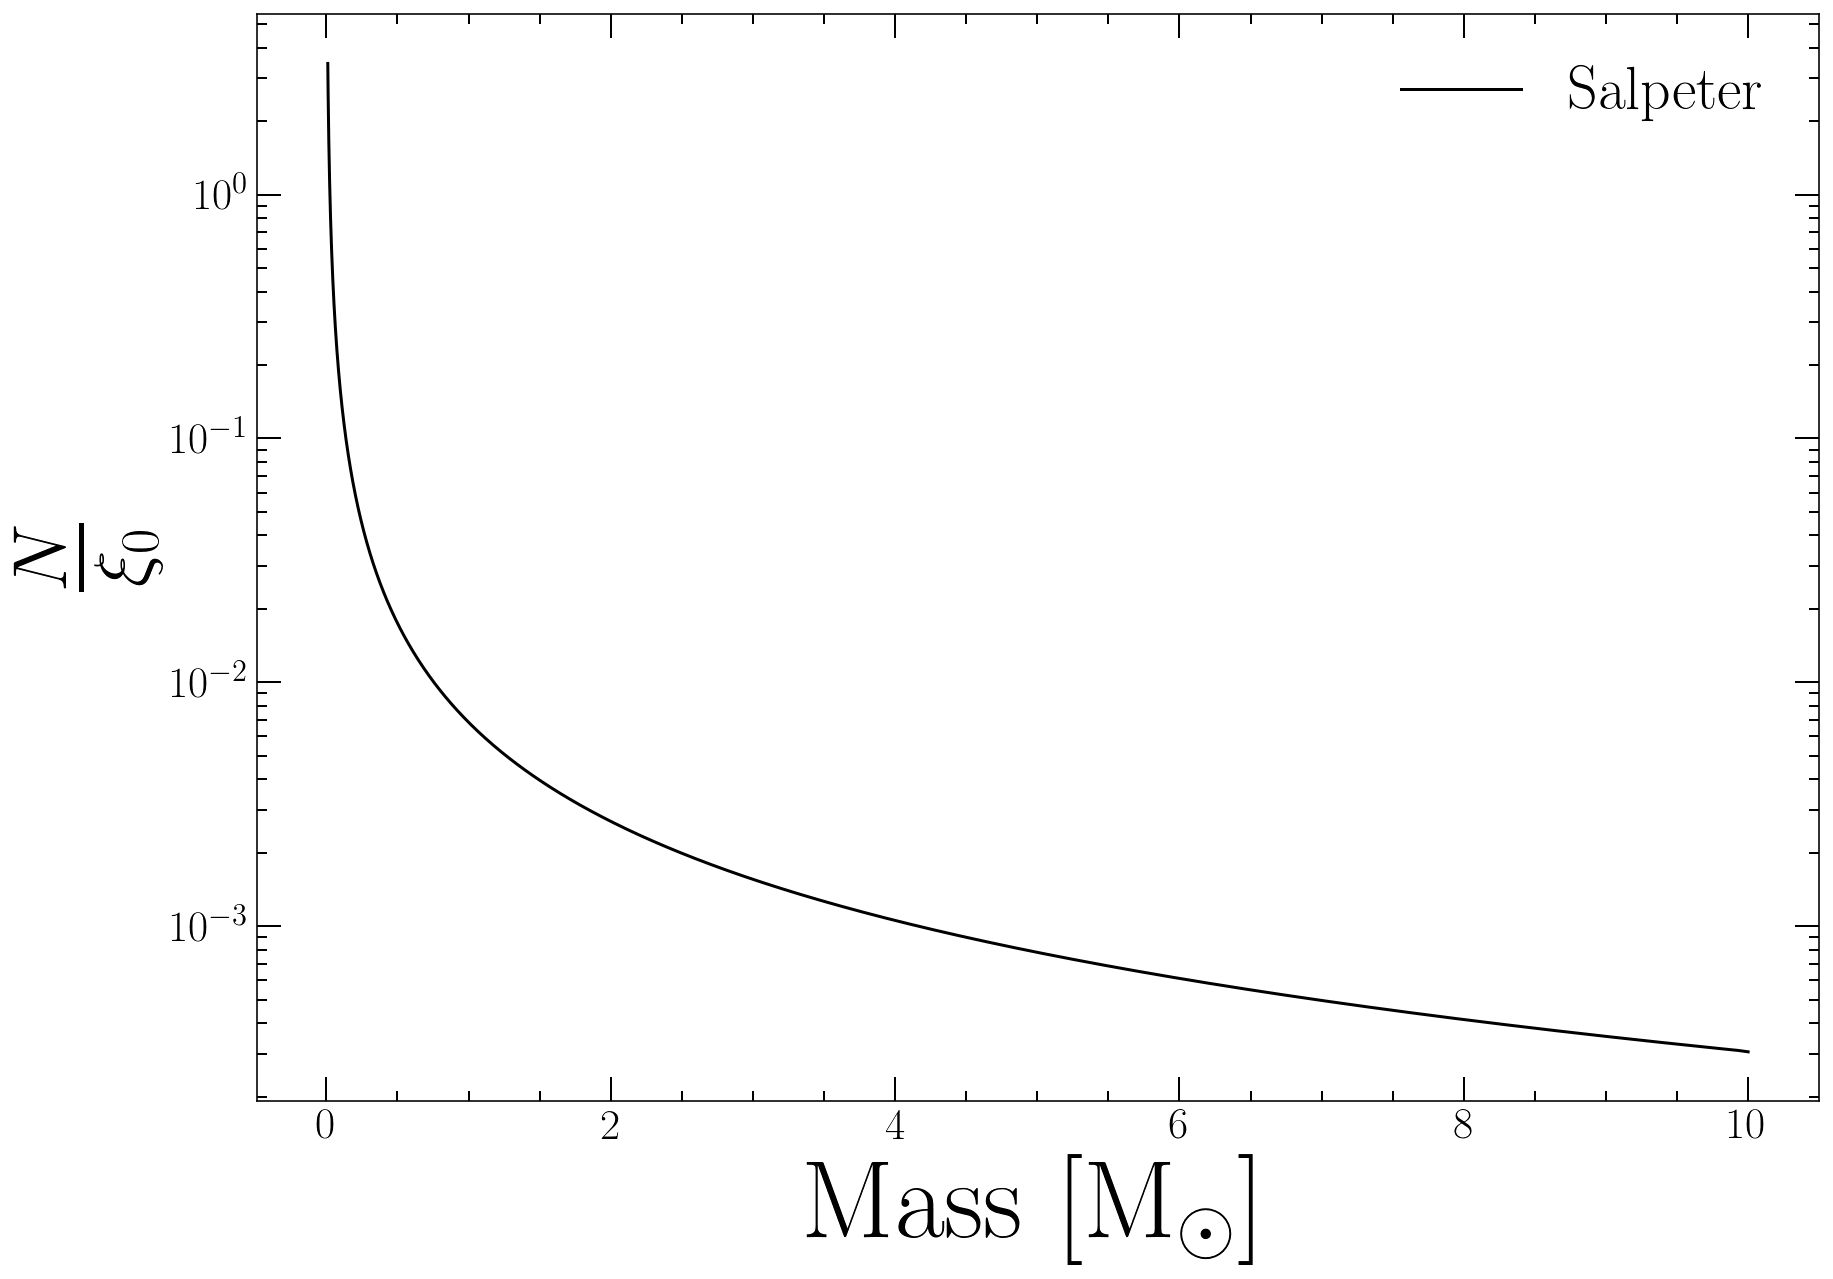

In [85]:
m = np.logspace(-2,1, 1000)
dm = np.gradient(m)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
# fig.patch.set_facecolor(bgColor)
# ax.set_facecolor(bgColor)
ax.semilogy(m, Salpeter(m, dm, 1), label='Salpeter', color='black')
# ax.semilogy(m, Kroupa(m, dm, 1), label='Kroupa', color='black', linestyle='dashed')
# ax.loglog(m, ChabrierSingle(m, 1), label="Chabrier Single")

ax.set_xlabel('Mass [M$_{\odot}$]', fontsize=55)
ax.set_ylabel(r'$\frac{N}{\xi_{0}}$', fontsize=55)


ax.legend(fontsize=30, frameon=False)

ax.tick_params(length=12, width=1)
ax.tick_params(length=5, width=1, which='minor')
ax.tick_params(axis='both', which='major', labelsize=22)

fig.savefig("figures/IMFJustSalpeter.png", bbox_inches="tight", transparent=True)

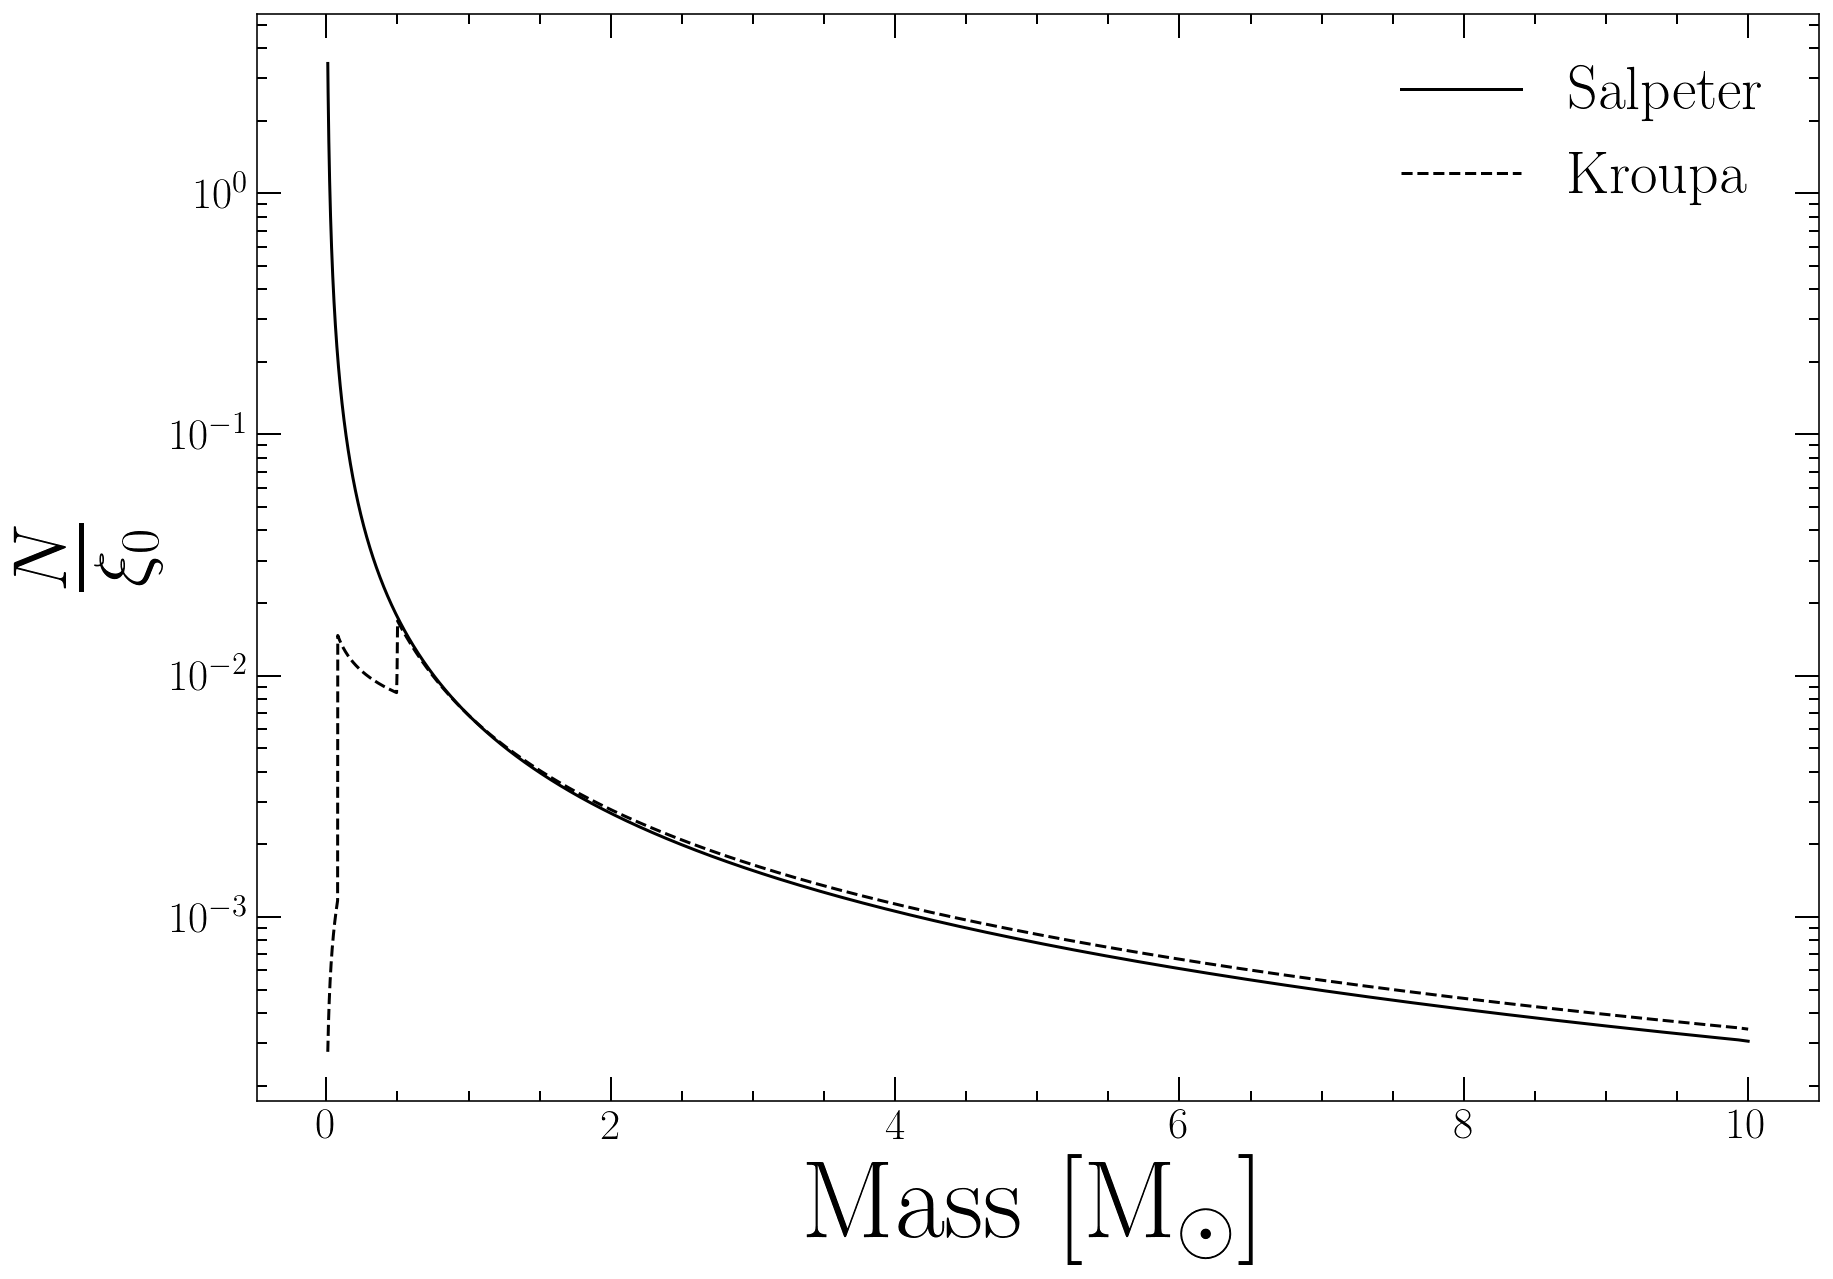

In [86]:
m = np.logspace(-2,1, 1000)
dm = np.gradient(m)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
# fig.patch.set_facecolor(bgColor)
# ax.set_facecolor(bgColor)
ax.semilogy(m, Salpeter(m, dm, 1), label='Salpeter', color='black')
ax.semilogy(m, Kroupa(m, dm, 1), label='Kroupa', color='black', linestyle='dashed')
# ax.loglog(m, ChabrierSingle(m, 1), label="Chabrier Single")

ax.set_xlabel('Mass [M$_{\odot}$]', fontsize=55)
ax.set_ylabel(r'$\frac{N}{\xi_{0}}$', fontsize=55)


ax.legend(fontsize=30, frameon=False)

ax.tick_params(length=12, width=1)
ax.tick_params(length=5, width=1, which='minor')
ax.tick_params(axis='both', which='major', labelsize=22)
fig.savefig("figures/IMFBoth.png", bbox_inches="tight", transparent=True)

In [87]:
dm = np.gradient(m)

In [88]:
dm[0]

6.938631476027628e-05

In [89]:
m[1]-m[0]

6.938631476027628e-05

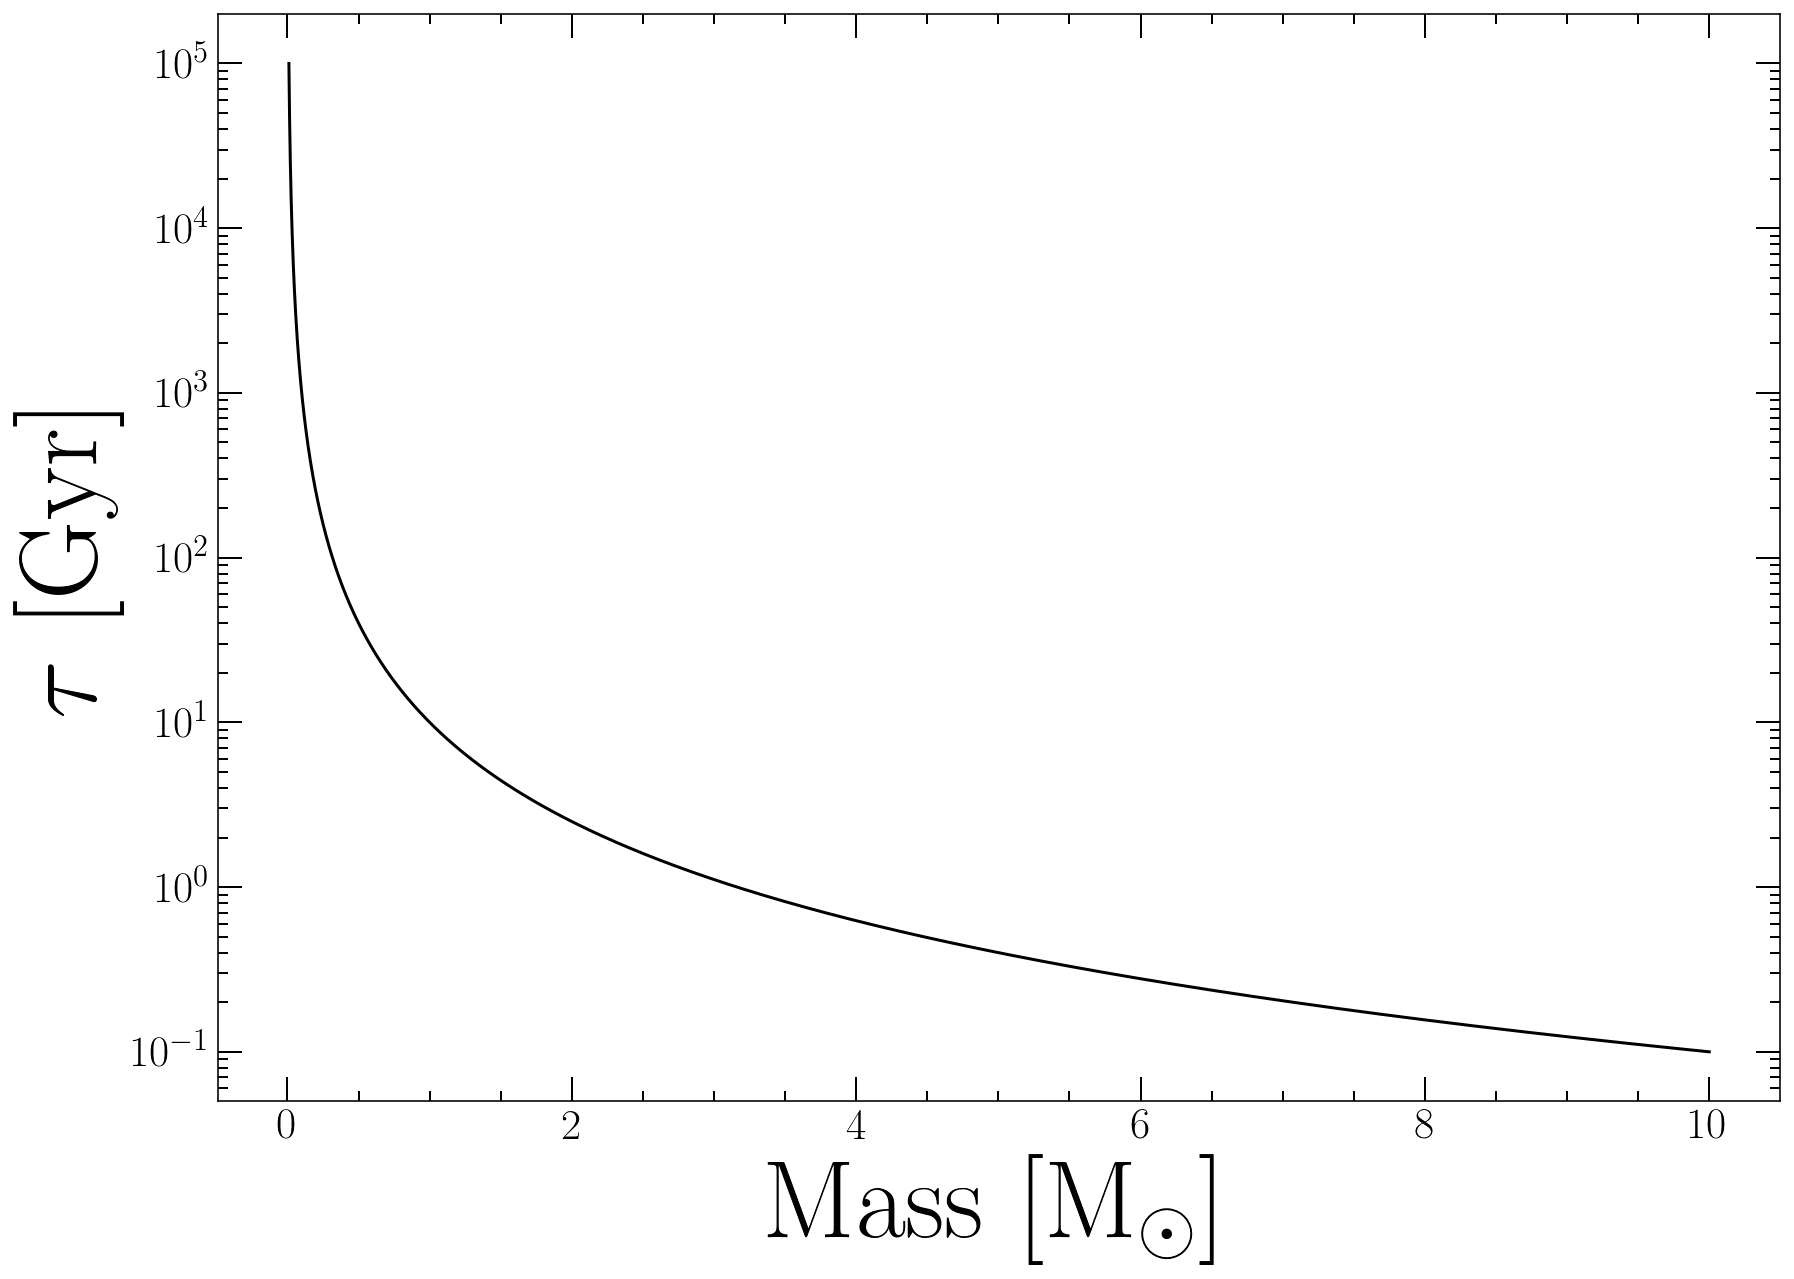

In [90]:
tau = lambda x, tau0: tau0 * x**-2 
m = np.logspace(-2, 1, 1000)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.semilogy(m, tau(m, 10), color='black')

ax.set_xlabel('Mass [M$_{\odot}$]', fontsize=55)
ax.set_ylabel(r'$\tau$ [Gyr]', fontsize=55)

ax.tick_params(length=12, width=1)
ax.tick_params(length=5, width=1, which='minor')
ax.tick_params(axis='both', which='major', labelsize=22)
fig.savefig("figures/MSLifeTime.png", bbox_inches="tight", transparent=True)

In [97]:
j = pd.read_csv("Gaia100ly.csv")
j = j.dropna(subset=['bp_rp', 'phot_g_mean_mag'])

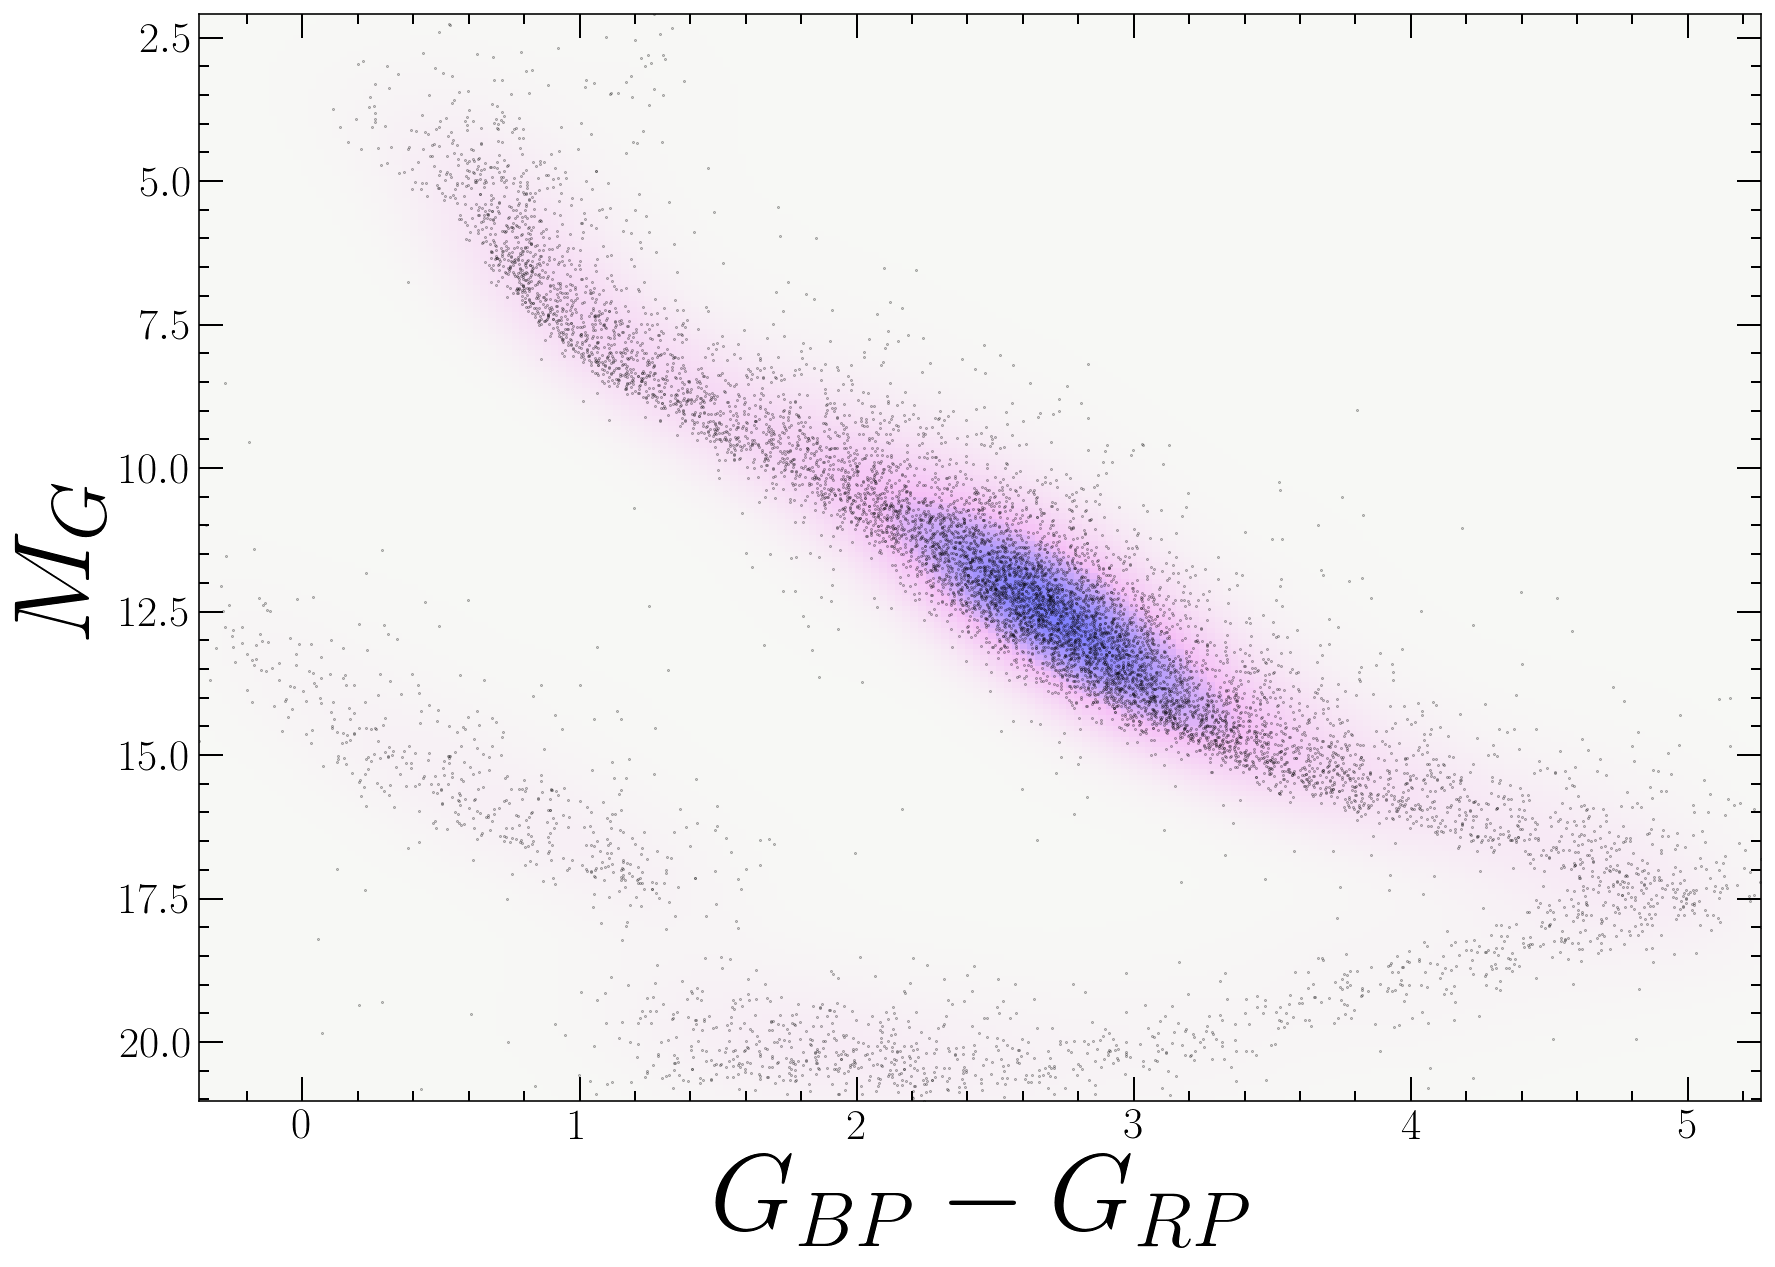

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.scatter(j['bp_rp'], j['phot_g_mean_mag'],s=0.1, color='black', alpha=0.5)
# fig.patch.set_facecolor(bgColor)
# ax.set_facecolor(bgColor)
add_kde_to_ax(j['bp_rp'], j['phot_g_mean_mag'], ax, alpha=0.5)
ax.invert_yaxis()

ax.set_xlabel("$G_{BP} - G_{RP}$", fontsize=55)
ax.set_ylabel("$M_{G}$", fontsize=55)
ax.tick_params(length=12, width=1)
ax.tick_params(length=5, width=1, which='minor')
ax.tick_params(axis='both', which='major', labelsize=22)

fig.savefig("figures/LocalCMD100ly.png", bbox_inches='tight', transparent=True)

In [54]:
def load_data(path):
    data = dict()
    for filepath in Path(path).rglob("*.out"):
        age = float(str(filepath).split('/')[-2][:-3])
        if age not in data:
            data[age] = dict()
        num = int(str(filepath).split('/')[-1].split('_')[1][:-4])
        data[age][num] = np.loadtxt(filepath, delimiter=",")
    return data

In [55]:
def plot_CMD(data, ax=None, bounds=None, po=True,kde_b=True,fmt="k.",kdealpha=1,poalpha=1):
    G = data[:, 6]
    BP = data[:, 7]
    RP = data[:, 8]

    BPRP = BP-RP

    if not bounds:
        xmin = np.min(BPRP)
        xmax = np.max(BPRP)
        ymin = np.min(G)
        ymax = np.max(G)
    else:
        xmin = bounds[0][0]
        xmax = bounds[0][1]
        ymin = bounds[1][0]
        ymax = bounds[1][1]
    X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    positions = np.vstack([X.ravel(), Y.ravel()])

    kde = gaussian_kde(np.vstack((BPRP, G)))
    Z = np.reshape(kde(positions).T, X.shape)

    mult = False

    if not ax:
        fig, axs = plt.subplots(1, 2, figsize=(10, 7))
        mult=True
    else:
        if isinstance(ax, np.ndarray):
            mult = True
            axs = ax

    if mult:
        imax = axs[0]
    else:
        imax = ax
    if kde_b:
        norm=plt.Normalize(Z.min(),Z.max())
        cmap = LinearSegmentedColormap.from_list("", [bgColor,"violet","blue"])
        imax.imshow(np.rot90(Z), cmap=cmap,
                  extent=[xmin, xmax, ymin, ymax],aspect='auto',alpha=kdealpha)

    if mult:
        axs[1].plot(BP - RP, G, fmt,alpha=poalpha)
    if not mult and po:
        imax.plot(BP - RP, G, fmt,alpha=poalpha)
    imax.invert_yaxis()
    if mult:
        axs[1].invert_yaxis()
    
    if bounds:
        imax.set_xlim(bounds[0][0],bounds[0][1])
        imax.set_ylim(bounds[1][0],bounds[1][1])
    if not ax:
        return fig, axs

In [56]:
opal_path = "/mnt/Astronomy/GraduateSchool/Thesis/JaoOpacity/ext_data/FineAgeRun_OPAL/"
tops_path = "/mnt/Astronomy/GraduateSchool/Thesis/JaoOpacity/ext_data/FineAgeRun_TOPS/"

In [57]:
data_opal = load_data(opal_path)
data_tops = load_data(tops_path)

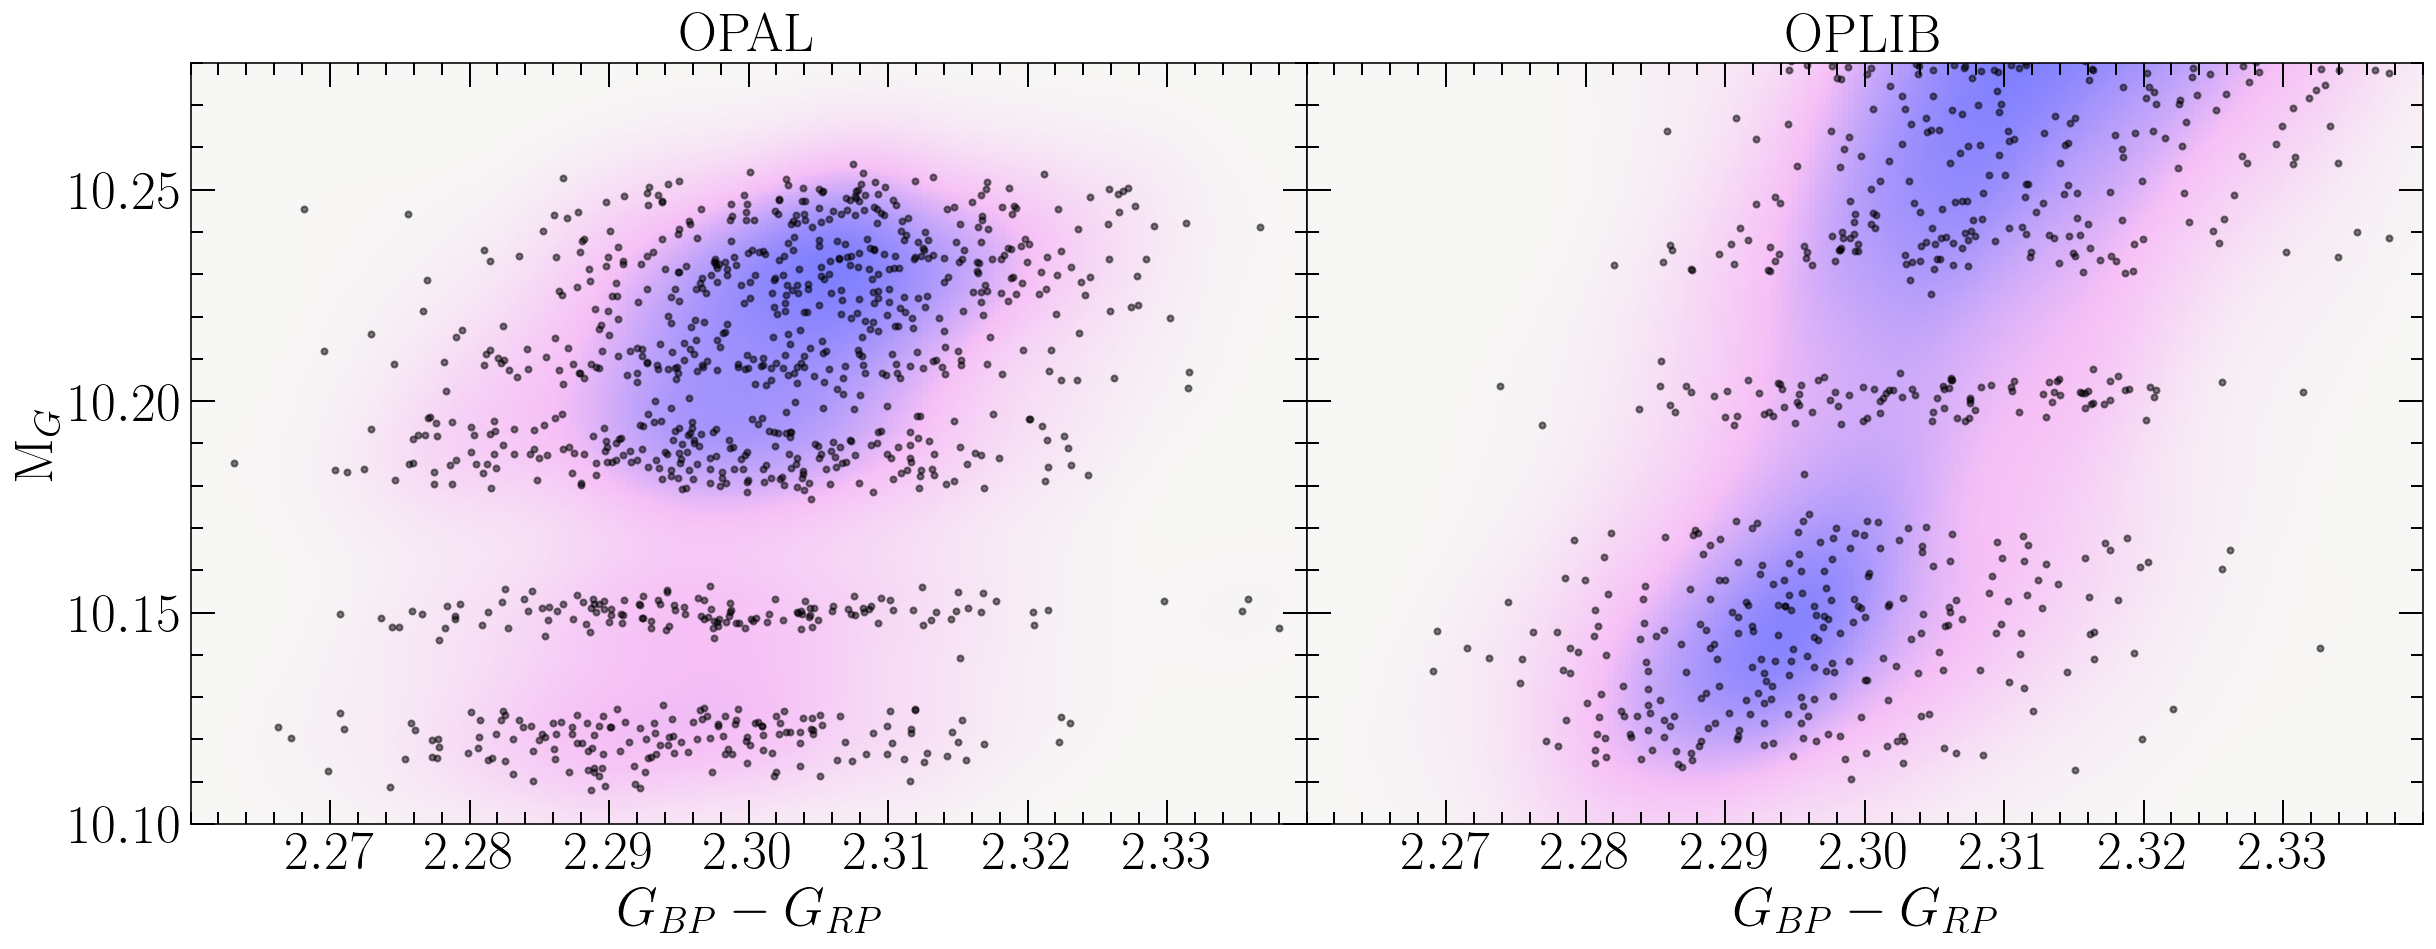

In [151]:

bounds = ((2.26, 2.34),(10.1, 10.28))
fig, axs = plt.subplots(1, 2, figsize=(20,7))
plot_CMD(data_opal[6][1000], ax=axs[0],kde_b=True,po=True,poalpha=0.5,bounds=bounds,kdealpha=0.5)
plot_CMD(data_tops[6][1000], ax=axs[1],kde_b=True,fmt="k.",po=True,poalpha=0.5,bounds=bounds,kdealpha=0.5)

axs[0].set_xlabel("$G_{BP} - G_{RP}$", fontsize=27)
axs[1].set_xlabel("$G_{BP} - G_{RP}$", fontsize=27)
axs[0].set_ylabel("M$_{G}$", fontsize=27)

axs[1].set_yticklabels([]);

axs[0].set_title("OPAL", fontsize=27)
axs[1].set_title("OPLIB", fontsize=27)
    
for ax in axs:
    ax.tick_params('both', length=12, width=1, which='major')
    ax.tick_params('both', length=6, width=1, which='minor')
    ax.tick_params(axis='x',labelsize=27)
    ax.tick_params(axis='y',labelsize=27)
    ax.xaxis.set_major_locator(MaxNLocator(prune='both'))

fig.subplots_adjust(wspace=0, hspace=0)

fig.savefig("figures/OPALOPLIB_popsynth_comp.png", bbox_inches="tight", transparent=True, dpi=200)

In [58]:
rootPath = "/mnt/Astronomy/GraduateSchool/Thesis/JaoAgeDateing/Observational/ext_data/FineAgeRun/"
data = load_data(rootPath)

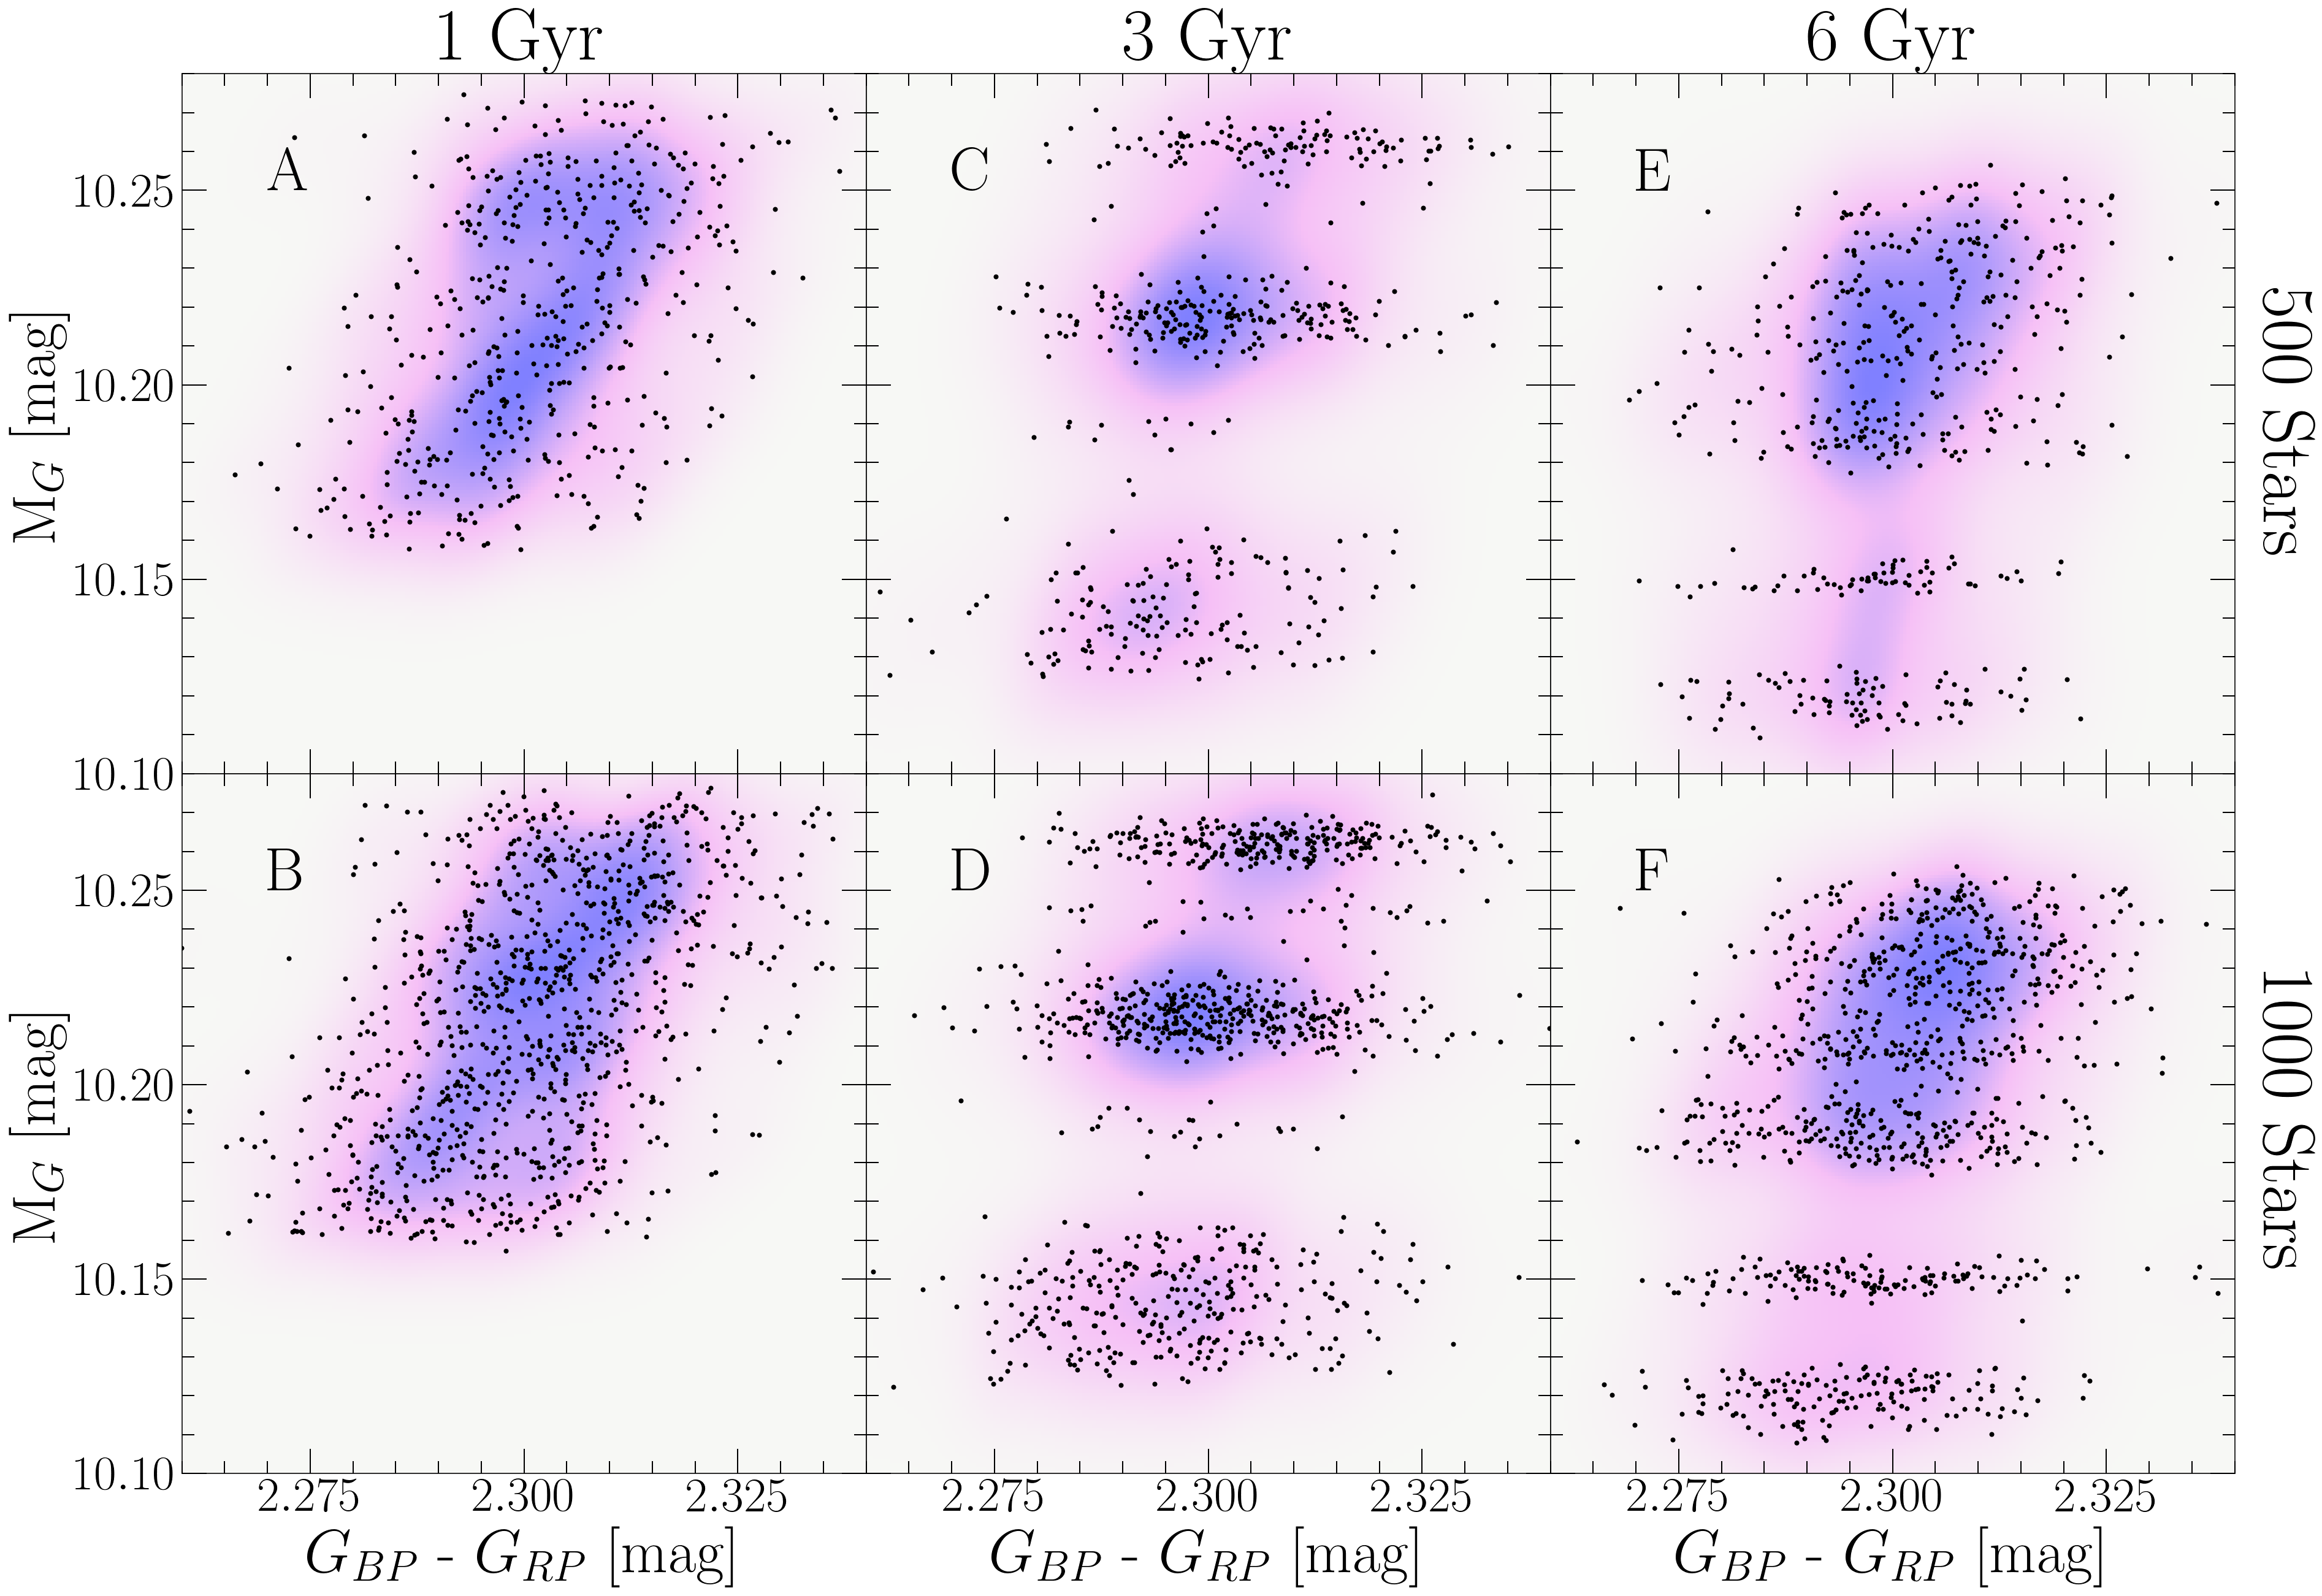

In [163]:
bounds = ((2.26, 2.34),(10.1, 10.28))
po = True
fig, axs = plt.subplots(2,3,figsize=(30,21))

axs[0,0].set_xticklabels([]);
for idx in range(1,3):
    axs[0, idx].set_yticklabels([]);
    axs[1, idx].set_yticklabels([]);
    axs[0, idx].set_xticklabels([]);

    
    
plot_CMD(data[1][500],ax=axs[0,0],bounds=bounds,po=po, kdealpha=0.5)
plot_CMD(data[3][500],ax=axs[0,1],bounds=bounds,po=po, kdealpha=0.5)
plot_CMD(data[6][500],ax=axs[0,2],bounds=bounds,po=po, kdealpha=0.5)

plot_CMD(data[1][1000],ax=axs[1,0],bounds=bounds,po=po, kdealpha=0.5)
plot_CMD(data[3][1000],ax=axs[1,1],bounds=bounds,po=po, kdealpha=0.5)
plot_CMD(data[6][1000],ax=axs[1,2],bounds=bounds,po=po, kdealpha=0.5)

fig.subplots_adjust(wspace=0, hspace=0)

uppercase = iter(string.ascii_uppercase)
for colID in range(3):
    for rowID in range(2):
        axs[rowID,colID].tick_params('both', length=20, width=1, which='major')
        axs[rowID,colID].tick_params('both', length=10, width=1, which='minor')
        axs[rowID,colID].tick_params(axis='x',labelsize=40)
        axs[rowID,colID].tick_params(axis='y',labelsize=40)
        axs[rowID,colID].annotate(next(uppercase), xy=(2.27,10.25),fontsize=50)
        
axs[0][0].set_ylabel("M$_{G}$ [mag]", fontsize=50)
axs[1][0].set_ylabel("M$_{G}$ [mag]", fontsize=50)

axs[1][0].set_xlabel("$G_{BP}$ - $G_{RP}$ [mag]", fontsize=50)
axs[1][1].set_xlabel("$G_{BP}$ - $G_{RP}$ [mag]", fontsize=50)
axs[1][2].set_xlabel("$G_{BP}$ - $G_{RP}$ [mag]", fontsize=50)

axs[0][2].yaxis.set_label_position("right")
axs[0][2].set_ylabel("500 Stars",fontsize=60,rotation=270, labelpad=64)

axs[1][2].yaxis.set_label_position("right")
axs[1][2].set_ylabel("1000 Stars", fontsize=60, rotation=270, labelpad=64)

axs[0][0].set_title("1 Gyr", fontsize=60)
axs[0][1].set_title("3 Gyr", fontsize=60)
axs[0][2].set_title("6 Gyr", fontsize=60)


fig.savefig("figures/JaoGapTheoreticalTimeEvolution.png", bbox_inches='tight', dpi=200, transparent=True)

In [155]:
rootPath

'/mnt/Astronomy/GraduateSchool/Thesis/JaoOpacity/ext_data/firstTestRun'

In [50]:
def Kippenhan_Iben(age, radius, convectiveMask, ageTrk, Teff, L, R, He3):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    axes = [ax, ax.twinx(), ax.twinx(), ax.twinx(), ax.twinx()]
    # fig.subplots_adjust(right=0.75)

    axes[2].spines['right'].set_position(('axes', 1.6))
    axes[3].spines['right'].set_position(('axes', 1.4))
    axes[4].spines['right'].set_position(('axes', 1.2))

    axes[2].set_frame_on(True)
    axes[2].patch.set_visible(False)
    axes[3].set_frame_on(True)
    axes[3].patch.set_visible(False)
    axes[4].set_frame_on(True)
    axes[4].patch.set_visible(False)

    colors = ('#332288', '#44AA99', '#000000', '#AA4499')
    norm=plt.Normalize(0,1)
    cmap = LinearSegmentedColormap.from_list("", ["grey", bgColor])
    axes[0].pcolormesh(age, radius, convectiveMask.T, hatch='/', cmap=cmap)
    axes[0].set_xlabel('Age [Gyr]', fontsize=27)
    axes[0].set_ylabel('Radius Fraction', fontsize=27)

    axes[1].plot(ageTrk, Teff, color=colors[0])
    axes[1].set_ylabel(r'$T_{core,6}$ [K]', fontsize=27, color=colors[0])
    axes[1].tick_params(axis='y', colors=colors[0])

    axes[2].plot(ageTrk, L, color=colors[1])
    axes[2].set_ylabel(r'L/L$_{ZAMS}$', fontsize=27, color=colors[1])
    axes[2].tick_params(axis='y', colors=colors[1])

    axes[3].plot(ageTrk, R, color=colors[2])
    axes[3].set_ylabel(r'R/R$_{ZAMS}$', fontsize=27, color=colors[2])
    axes[3].tick_params(axis='y', colors=colors[2])

    axes[4].plot(ageTrk, He3, color=colors[3])
    axes[4].set_ylabel(r'X($^{3}$He)$_{core}$', fontsize=27, color=colors[3])
    axes[4].tick_params(axis='y', colors=colors[3])

    return fig, axes

/tmp/ipykernel_13118/1415347038.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0].pcolormesh(age, radius, convectiveMask.T, hatch='/', cmap=cmap)


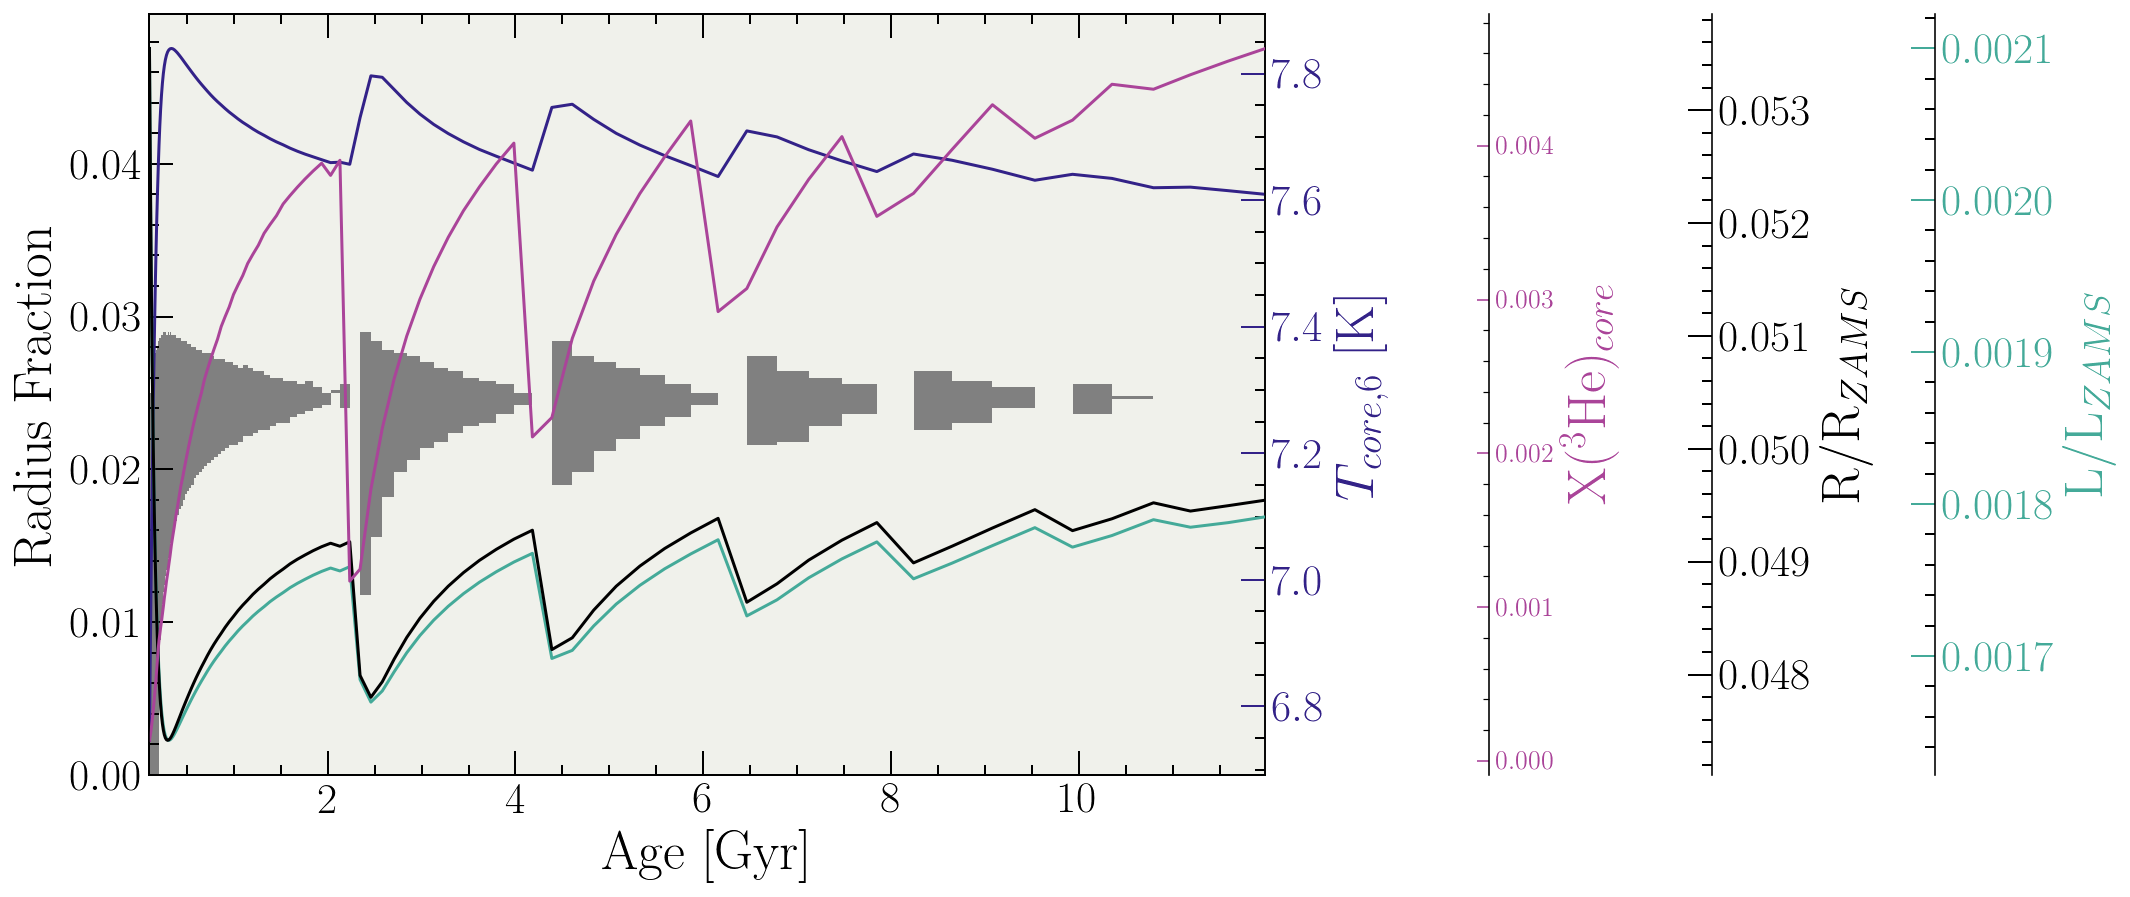

In [51]:
kipPath = "Models/M0.35654999999999915_model/"
files = os.listdir(kipPath)
binMods = filter(lambda x: x.endswith('.binmod'), files)
trks = filter(lambda x: x.endswith('.track'), files)

binModFile = next(binMods)
trkFile = next(trks)

binModPath = os.path.join(kipPath, binModFile)
trkPath = os.path.join(kipPath, trkFile)

headers, cards = read_bin_mod(binModPath)
trks, metas = read_trk(trkPath)
trk = trks[0]

minAge = 0.1
maxAge = 12

age = headers[:, 1]
ageMask = age[(age <= maxAge) & (age >= minAge)]

trkAgeCond = (trk['AGE'] <= maxAge) & (trk['AGE'] >= minAge)
trkAge = trk['AGE'][trkAgeCond]

ClogT = trk['C_log_T']
Teff = ClogT[trkAgeCond]

LLZAMS = ((10**trk['log_L'])/(10**trk.iloc[0]['log_L']))[trkAgeCond]

RRZAMS = ((10**trk['log_R'])/(10**trk.iloc[0]['log_R']))[trkAgeCond]

He3 = trk['CA_He3'][trkAgeCond]


convectiveMask = cards[:, 5, :]
radius = np.linspace(0, 1, convectiveMask.T.shape[0])

radiusCut = 0.05

convectiveMaskF = convectiveMask[(age <= maxAge) & (age >= minAge)]
convectiveMaskF = convectiveMaskF[:,radius < radiusCut]

fig, axes = Kippenhan_Iben(ageMask, radius[radius < radiusCut], convectiveMaskF, trkAge, (10**Teff)/1e6, LLZAMS, RRZAMS, He3)
axes[0].tick_params(length=12, width=1)
axes[0].tick_params(length=5, width=1, which='minor')
axes[0].tick_params(axis='both', which='major', labelsize=22)

axes[1].tick_params(length=12, width=1)
axes[1].tick_params(length=5, width=1, which='minor')
axes[1].tick_params(axis='both', which='major', labelsize=22)

axes[2].tick_params(length=12, width=1)
axes[2].tick_params(length=5, width=1, which='minor')
axes[2].tick_params(axis='both', which='major', labelsize=22)

axes[3].tick_params(length=12, width=1)
axes[3].tick_params(length=5, width=1, which='minor')
axes[3].tick_params(axis='both', which='major', labelsize=22)

fig.savefig("figures/Kippenhan.png", bbox_inches="tight", transparent=True, dpi=200)

In [33]:
trkAge

237     0.103967
238     0.109165
239     0.114623
240     0.120355
241     0.126372
         ...    
337    10.349450
338    10.790927
339    11.184429
340    11.586439
341    11.982795
Name: AGE, Length: 105, dtype: float64

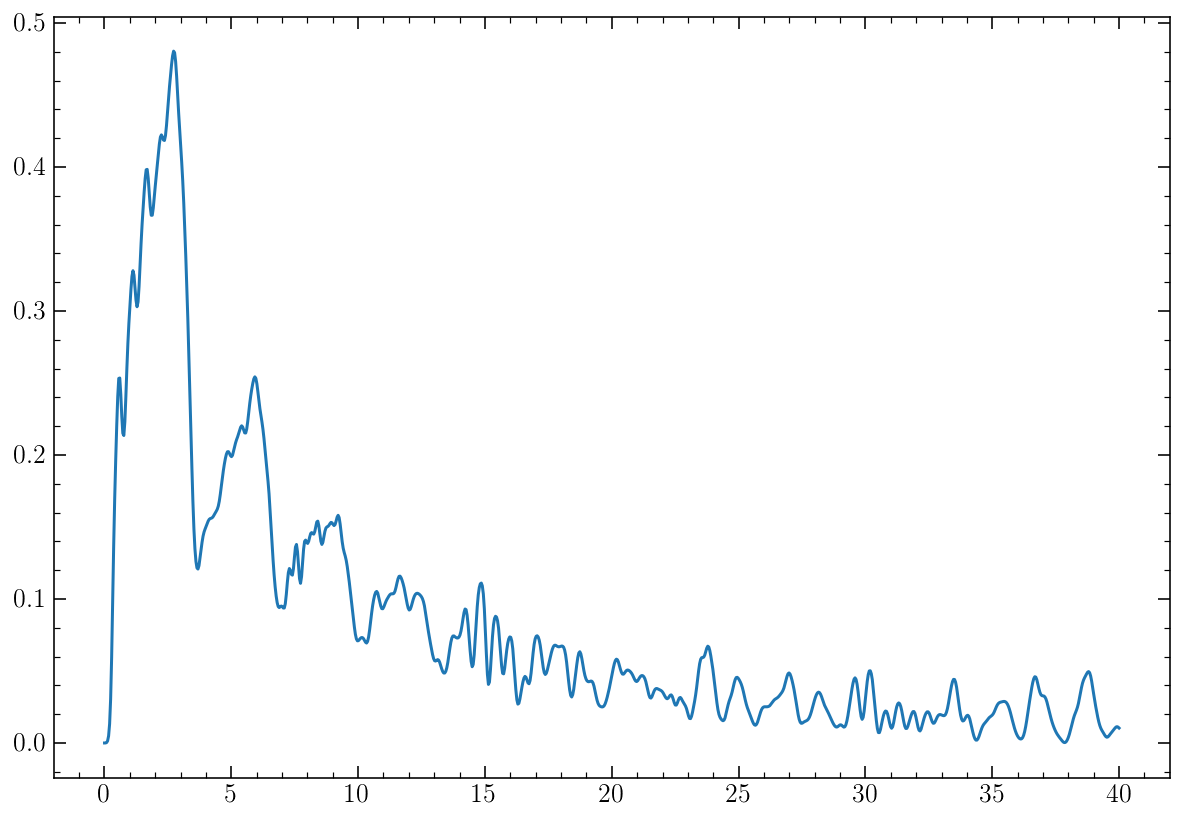

In [43]:
line = lambda x, m, b: m*x+b

fit, cover = curve_fit(line, trkAge, He3)

nyquist = (1/2)*(trkAge.iloc[1]-trkAge.iloc[0])
w = np.linspace(40, nyquist, 1000)

norm = He3-line(trkAge,*fit)

pgram = lombscargle(trkAge,  norm, w, normalize=True)
# plt.plot(trkAge, He3-line(trkAge, *fit))
plt.plot(w, pgram)

In [44]:
1/2.5

0.4

In [86]:
bounds = ((2.26, 2.34),(10.1, 10.28))
po = True


fps = 15
with animation("animations/GapSmear.mp4", dpi=50, fps=fps) as anim:
    for _ in tqdm(range(2*fps), desc="Init"):
        fig, ax = plt.subplots(1,1,figsize=(10,7))
        ax.tick_params('both', length=20, width=1, which='major')
        ax.tick_params('both', length=10, width=1, which='minor')
        ax.tick_params(axis='x',labelsize=40)
        ax.tick_params(axis='y',labelsize=40)

        ax.set_ylabel("M$_{G}$ [mag]", fontsize=50)

        ax.set_xlabel("$G_{BP}$ - $G_{RP}$ [mag]", fontsize=50)

        plot_CMD(data[6][1000],ax=ax,bounds=bounds,po=po, kdealpha=0)
        anim.add_frame(fig)
        plt.close(fig)

    dataC = data[6][1000].copy()
    for scale in tqdm(np.linspace(0, 0.1, 4*fps), desc="smear"):
        fig, ax = plt.subplots(1,1,figsize=(10,7))
        ax.tick_params('both', length=20, width=1, which='major')
        ax.tick_params('both', length=10, width=1, which='minor')
        ax.tick_params(axis='x',labelsize=40)
        ax.tick_params(axis='y',labelsize=40)

        ax.set_ylabel("M$_{G}$ [mag]", fontsize=50)

        ax.set_xlabel("$G_{BP}$ - $G_{RP}$ [mag]", fontsize=50)
        plot_CMD(data[6][1000],ax=ax,bounds=bounds,po=po, kdealpha=0)
        dataC[:,6] += np.random.normal(loc=0,scale=0.01,size=dataC[:,6].shape)

        plot_CMD(dataC,ax=ax,bounds=bounds,po=po,kdealpha=0,fmt="k.")
        
        anim.add_frame(fig)
        plt.close(fig)






# fig.savefig("figures/JaoGapTheoreticalTimeEvolution.png", bbox_inches='tight', dpi=200, transparent=True)

smear: 100%|████████████████████████████████████| 60/60 [02:03<00:00,  2.06s/it]


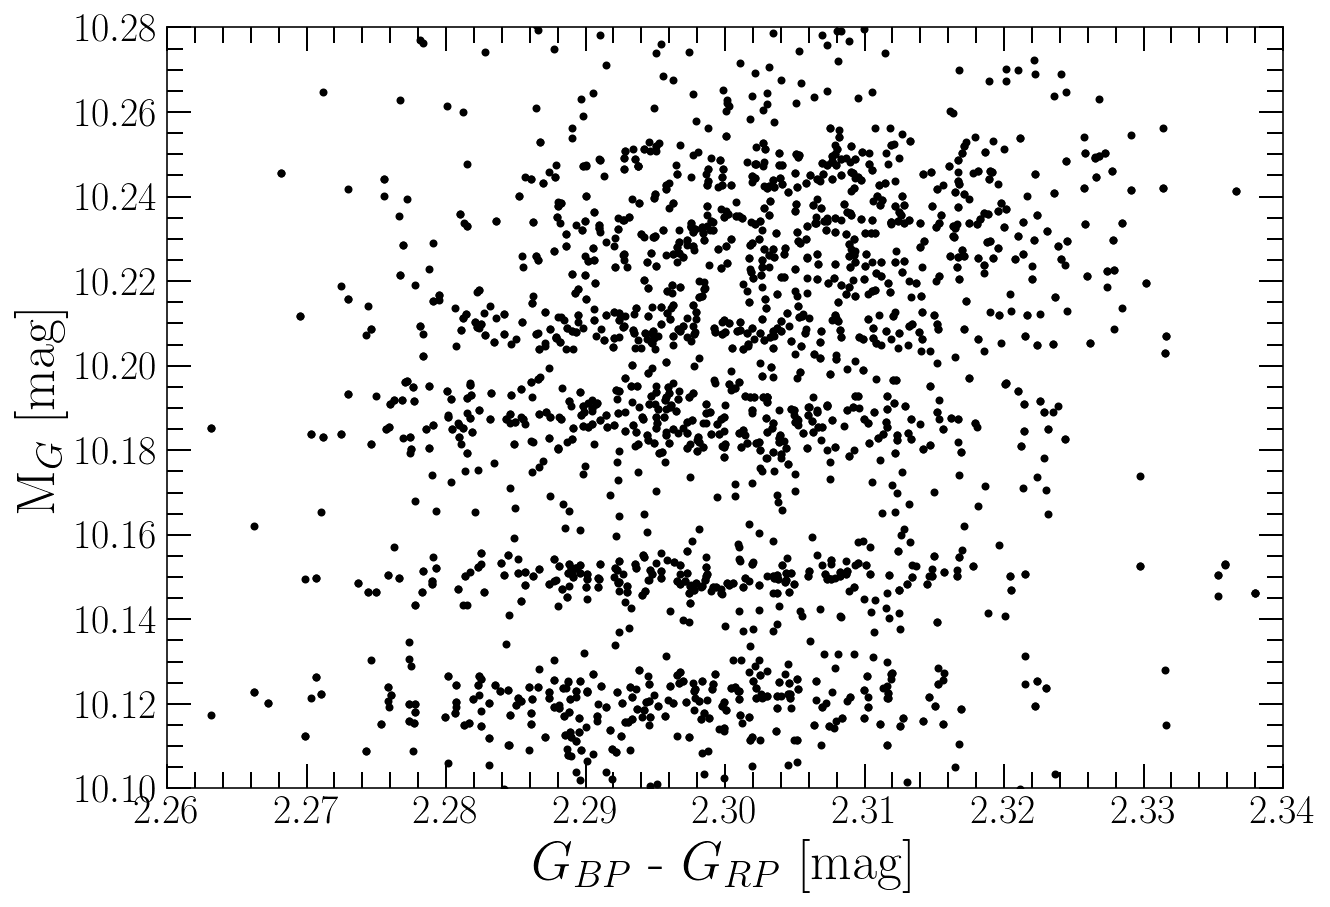

In [93]:
bounds = ((2.26, 2.34),(10.1, 10.28))
po = True


fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.tick_params('both', length=12, width=1, which='major')
ax.tick_params('both', length=8, width=1, which='minor')
ax.tick_params(axis='x',labelsize=20)
ax.tick_params(axis='y',labelsize=20)

ax.set_ylabel("M$_{G}$ [mag]", fontsize=27)

ax.set_xlabel("$G_{BP}$ - $G_{RP}$ [mag]", fontsize=27)

plot_CMD(data[6][1000],ax=ax,bounds=bounds,po=po, kdealpha=0)


plot_CMD(data[6][1000],ax=ax,bounds=bounds,po=po, kdealpha=0)
dataC[:,6] += np.random.normal(loc=0,scale=0.01,size=dataC[:,6].shape)

plot_CMD(dataC,ax=ax,bounds=bounds,po=po,kdealpha=0,fmt="k.")
        






fig.savefig("figures/JaoGapSmear.png", bbox_inches='tight', dpi=200, transparent=True)

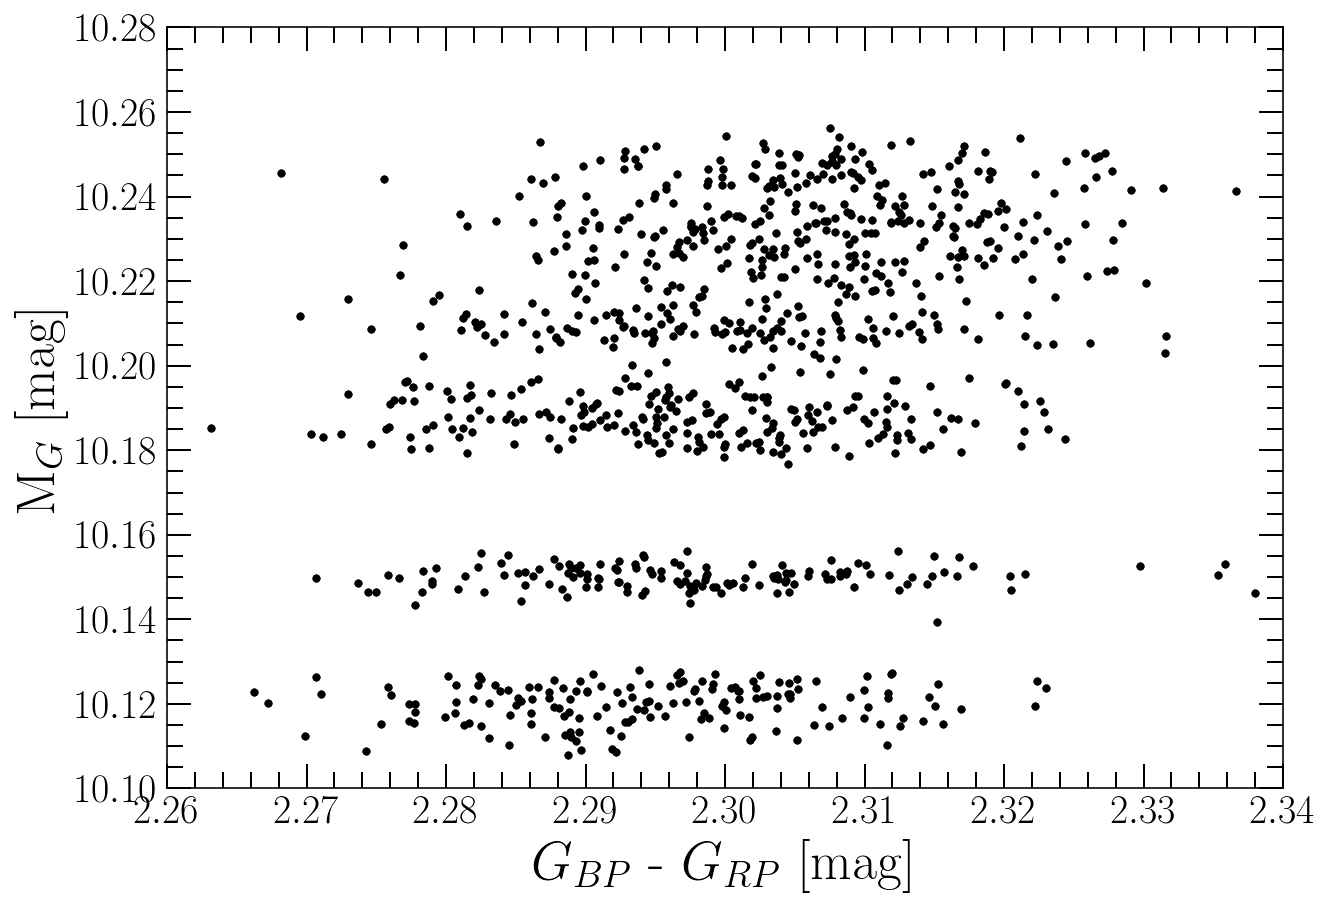

In [92]:

bounds = ((2.26, 2.34),(10.1, 10.28))
po = True


fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.tick_params('both', length=12, width=1, which='major')
ax.tick_params('both', length=8, width=1, which='minor')
ax.tick_params(axis='x',labelsize=20)
ax.tick_params(axis='y',labelsize=20)

ax.set_ylabel("M$_{G}$ [mag]", fontsize=27)

ax.set_xlabel("$G_{BP}$ - $G_{RP}$ [mag]", fontsize=27)

plot_CMD(data[6][1000],ax=ax,bounds=bounds,po=po, kdealpha=0)


plot_CMD(data[6][1000],ax=ax,bounds=bounds,po=po, kdealpha=0)
dataC[:,6] += np.random.normal(loc=0,scale=0.01,size=dataC[:,6].shape)

# plot_CMD(dataC,ax=ax,bounds=bounds,po=po,kdealpha=0,fmt="k.")
        






fig.savefig("figures/JaoGapnoSmear.png", bbox_inches='tight', dpi=200, transparent=True)